In [1]:
import os
import fitsio
import numpy as np 
from datetime import datetime
# --- astropy ---
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, get_sun, get_moon

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
ftile = '/Users/ChangHoon/data/desi/data/footprint/desi-tiles.fits'

In [4]:
tiles = fitsio.read(ftile)

In [5]:
in_desi = tiles['IN_DESI'].astype(bool)

Lets get the sun and moon coordinates

In [6]:
sun_ra, sun_dec = [], [] 
moon_ra, moon_dec = [], []
for year in range(2020, 2025):
    for month in range(1,13): 
        if month == 2: days = 28
        else: days = 30
        for day in range(1,days+1): 
            tt = Time(datetime(year, month, day, 12, 0, 0), scale='utc')
            _sun = get_sun(tt)
            sun_ra.append(_sun.ra.to(u.deg).value)
            sun_dec.append(_sun.dec.to(u.deg).value)

            _moon = get_moon(tt)
            moon_ra.append(_moon.ra.to(u.deg).value)
            moon_dec.append(_moon.dec.to(u.deg).value)
        
sun_ra = np.array(sun_ra)
sun_dec = np.array(sun_dec)
moon_ra = np.array(moon_ra)
moon_dec = np.array(moon_dec)

Text(0.5, 1.0, 'DESI footprint')

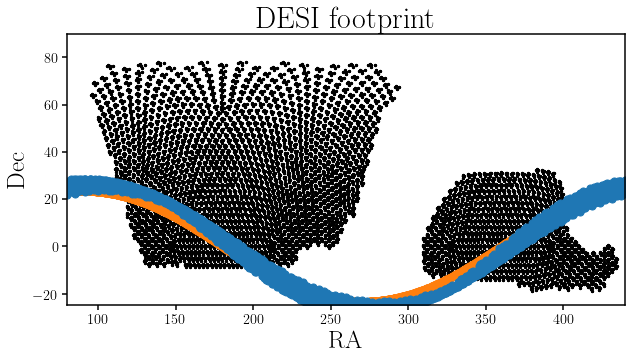

In [7]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(((tiles['RA'][in_desi] - 80) % 360) + 80, tiles['DEC'][in_desi], s=5, c='k')

sub.scatter(((sun_ra - 80) % 360) + 80, sun_dec, c='C1', s=50)
sub.scatter(((moon_ra - 80) % 360) + 80, moon_dec, c='C0', s=50)

sub.set_xlabel('RA', fontsize=25)
sub.set_xlim(80, 440)
sub.set_ylabel('Dec', fontsize=25)
sub.set_ylim(-25., 90.)
sub.set_title('DESI footprint', fontsize=30)

In [8]:
is_bgs = in_desi & (tiles['PROGRAM'] == 'BRIGHT')

Text(0.5, 1.0, 'BGS footprint: 5994 tiles')

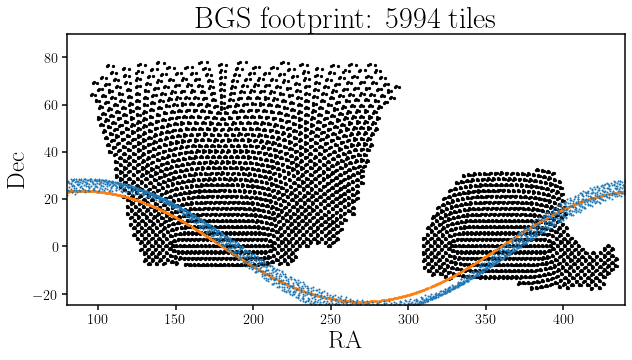

In [9]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(((tiles['RA'][is_bgs] - 80) % 360) + 80, tiles['DEC'][is_bgs], s=5, c='k')

sub.scatter(((sun_ra - 80) % 360) + 80, sun_dec, c='C1', s=1)
sub.scatter(((moon_ra - 80) % 360) + 80, moon_dec, c='C0', s=1)


sub.set_xlabel('RA', fontsize=25)
sub.set_xlim(80, 440)
sub.set_ylabel('Dec', fontsize=25)
sub.set_ylim(-25., 90.)
sub.set_title('BGS footprint: %i tiles' % np.sum(is_bgs), fontsize=30)

Now lets convert to ecliptic coordinates

In [10]:
sun_coord = SkyCoord(ra=sun_ra * u.deg, dec=sun_dec * u.deg, frame='icrs')
moon_coord = SkyCoord(ra=moon_ra * u.deg, dec=moon_dec * u.deg, frame='icrs')
tile_coord = SkyCoord(ra=tiles['RA'] * u.deg, dec=tiles['DEC'] * u.deg, frame='icrs')

Text(0.5, 1.0, 'BGS footprint: 5994 tiles, $14000 deg^2$')

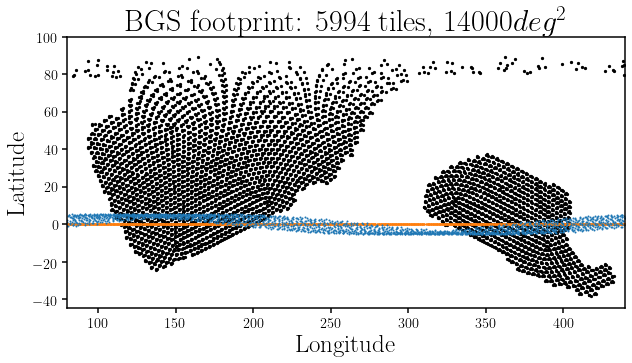

In [11]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(((tile_coord.barycentrictrueecliptic.lon.value[is_bgs]-80) % 360)+80, tile_coord.barycentrictrueecliptic.lat.value[is_bgs], s=5, c='k')
sub.scatter(((sun_coord.barycentrictrueecliptic.lon.value-80) % 360)+80, sun_coord.barycentrictrueecliptic.lat, s=1, c='C1')
sub.scatter(((moon_coord.barycentrictrueecliptic.lon.value-80) % 360)+80, moon_coord.barycentrictrueecliptic.lat, s=1, c='C0')
sub.set_xlabel('Longitude', fontsize=25)
sub.set_xlim(80, 440)
sub.set_ylabel('Latitude', fontsize=25)
sub.set_ylim(-45., 100.)
sub.set_title('BGS footprint: %i tiles, $%.f deg^2$' % (np.sum(is_bgs), 14000), fontsize=30)

In [12]:
is_ngc = (tile_coord.galactic.b.value >= 0.)
is_sgc = (tile_coord.galactic.b.value < 0.)

In [13]:
np.sum(is_bgs & is_ngc & (tile_coord.barycentrictrueecliptic.lat.to(u.deg).value < 8.1))/np.sum(is_bgs) * 14000

1992.3256589923258

In [20]:
foot13000 = ((is_bgs & is_ngc) |
             (is_bgs & is_sgc & (np.abs(tile_coord.barycentrictrueecliptic.lat.to(u.deg).value) > 6.5)))
foot12000 = ((is_bgs & is_ngc & (tile_coord.barycentrictrueecliptic.lat.to(u.deg).value > 8.1)) | 
             (is_bgs & is_sgc))
foot11000 = ((is_bgs & is_ngc & (tile_coord.barycentrictrueecliptic.lat.to(u.deg).value > 8.1)) | 
             (is_bgs & is_sgc & (np.abs(tile_coord.barycentrictrueecliptic.lat.to(u.deg).value) > 6.5)))
foot10000 = ((is_bgs & is_ngc & (tile_coord.barycentrictrueecliptic.lat.to(u.deg).value > 12.6)) | 
             (is_bgs & is_sgc & (np.abs(tile_coord.barycentrictrueecliptic.lat.to(u.deg).value) > 9.7)))

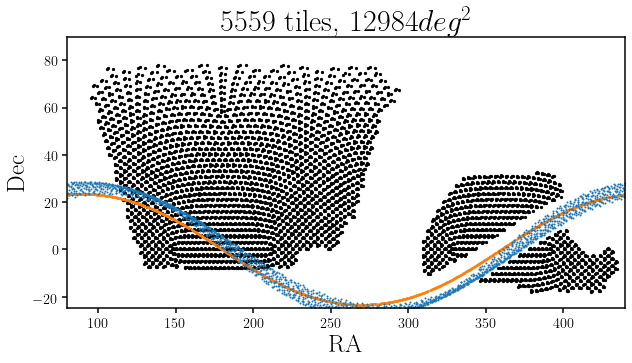

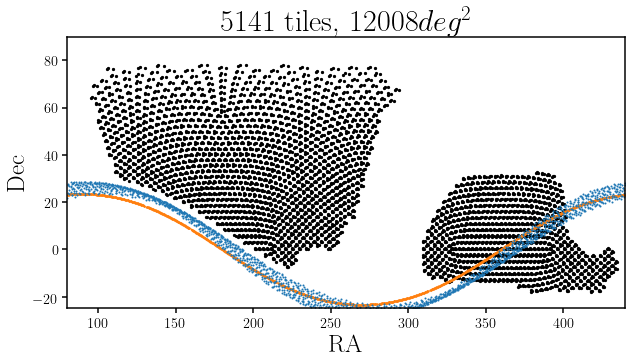

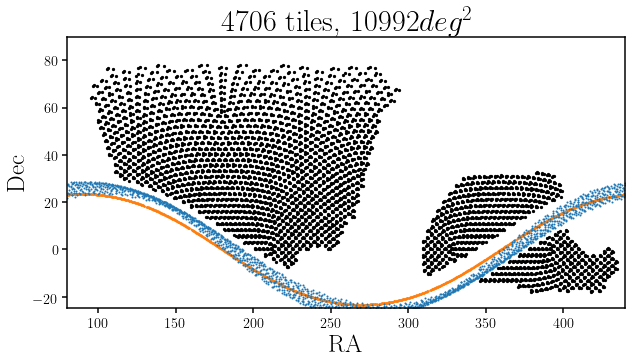

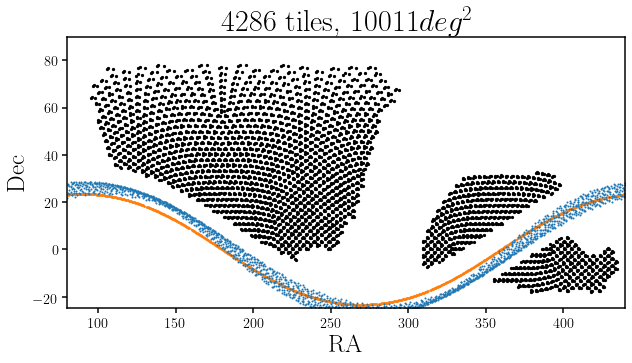

In [21]:
for _foot, lbl in zip([foot13000, foot12000, foot11000, foot10000], [13000, 12000, 11000, 10000]): 
    foot = is_bgs & _foot
    
    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111)
    
    sub.scatter(((tiles['RA'][foot] - 80) % 360) + 80, tiles['DEC'][foot], s=5, c='k')
    sub.scatter(((sun_ra - 80) % 360) + 80, sun_dec, c='C1', s=1)
    sub.scatter(((moon_ra - 80) % 360) + 80, moon_dec, c='C0', s=1)


    sub.set_xlabel('RA', fontsize=25)
    sub.set_xlim(80, 440)
    sub.set_ylabel('Dec', fontsize=25)
    sub.set_ylim(-25., 90.)

    sub.set_title('%i tiles, $%.f deg^2$' % (np.sum(foot), 14000 * float(np.sum(foot))/float(np.sum(is_bgs))), fontsize=30)